In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import albumentations as A
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)    

In [2]:
#모든 열 보기
pd.set_option('display.max_columns', None)

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
path = 'D:/Dataset/Competitons/cancer/'
train = pd.read_csv(path + 'train.csv').copy()
test = pd.read_csv(path + 'test.csv').copy()

In [4]:
clinical_info = pd.read_excel(path + 'clinical_info.xlsx').copy()

In [5]:
clinical_info

,항목,코딩,설명
0,ID,NaN,부여번호
1,나이,NaN,진단시 나이
2,수술연월일,연-월-일,NaN
3,진단명,1: ductal\n2: lobular\n3. mucinous \n4. other,histologic type
4,암의 위치,1: Right\n2: Left\n3: Both,NaN
5,암의 개수,1: single\n2: multiple,NaN
6,암의 장경,NaN,"암 Size (mm), 여러 개의 암일 경우 가장 큰 종양의 장경"
7,NG,1: NG1\n2: NG2\n3: NG3,"1은 핵의 모양이 정상에 가까운 경우, 2는 중간, 3은 정상으로부터 매우 달라진경..."
8,HG,1: HG1\n2: HG2\n3: HG3\n4. not graded,"Grade 1 (scores of 3, 4, or 5): 조직학적 분화도가 좋아서 ..."
9,HG_score_1,1: score 1\n2: score 2\n3: score 3\n4: not graded,(Tubule formation)\nScore 1 (>75% of tumor are...


In [6]:
train

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,1.0,2.0,2.0,1.0,2,NaN,1.0,1.0,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,3.0,3.0,3.0,3.0,0,NaN,2.0,0.0,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,NaN,NaN,NaN,NaN,1,2.0,0.0,1.0,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,2.0,3.0,2.0,1.0,2,NaN,1.0,1.0,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,./train_imgs/BC_01_3464.png,-,65,2006-12-22,1,2,1,25.0,1.0,1.0,2.0,1.0,1.0,0,NaN,2.0,1.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
996,BC_01_3482,./train_imgs/BC_01_3482.png,-,48,2006-11-17,1,1,1,7.0,1.0,1.0,1.0,1.0,1.0,0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
997,BC_01_3485,./train_imgs/BC_01_3485.png,-,64,2006-11-10,1,2,1,15.0,1.0,1.0,2.0,1.0,2.0,0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
998,BC_01_3502,./train_imgs/BC_01_3502.png,-,50,2006-09-22,1,1,1,7.0,1.0,1.0,1.0,2.0,1.0,0,NaN,1.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0


In [7]:
train['img_path'] = [path  + j[2:] for j in train['img_path']]
train['mask_path'] = [path  + j[2:] for j in train['mask_path']]
train

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,63,2015-10-23,1,2,1,19.0,2.0,1.0,2.0,2.0,1.0,2,NaN,1.0,1.0,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,51,2015-10-28,1,1,1,22.0,3.0,3.0,3.0,3.0,3.0,0,NaN,2.0,0.0,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,37,2015-10-29,1,2,1,NaN,2.0,NaN,NaN,NaN,NaN,1,2.0,0.0,1.0,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,54,2016-03-08,1,2,1,0.0,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,57,2015-10-30,1,2,1,8.0,2.0,2.0,3.0,2.0,1.0,2,NaN,1.0,1.0,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,65,2006-12-22,1,2,1,25.0,1.0,1.0,2.0,1.0,1.0,0,NaN,2.0,1.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
996,BC_01_3482,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,48,2006-11-17,1,1,1,7.0,1.0,1.0,1.0,1.0,1.0,0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
997,BC_01_3485,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,64,2006-11-10,1,2,1,15.0,1.0,1.0,2.0,1.0,2.0,0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
998,BC_01_3502,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,50,2006-09-22,1,1,1,7.0,1.0,1.0,1.0,2.0,1.0,0,NaN,1.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0


In [8]:
train.isna().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             4
ER                     1
ER_Allred_score      297
PR                     1
PR_Allred_score      453
KI-67_LI_percent     235
HER2                  14
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
BRCA_mutation        945
N_category             0
dtype: int64

In [9]:
train['암의 장경'] = train['암의 장경'].fillna(train['암의 장경'].mean())
train = train.fillna(0)

test['암의 장경'] = test['암의 장경'].fillna(test['암의 장경'].mean())
test = test.fillna(0)

In [10]:
train.isna().sum()

ID                   0
img_path             0
mask_path            0
나이                   0
수술연월일                0
진단명                  0
암의 위치                0
암의 개수                0
암의 장경                0
NG                   0
HG                   0
HG_score_1           0
HG_score_2           0
HG_score_3           0
DCIS_or_LCIS_여부      0
DCIS_or_LCIS_type    0
T_category           0
ER                   0
ER_Allred_score      0
PR                   0
PR_Allred_score      0
KI-67_LI_percent     0
HER2                 0
HER2_IHC             0
HER2_SISH            0
HER2_SISH_ratio      0
BRCA_mutation        0
N_category           0
dtype: int64

In [11]:
ignore_cols_train = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']
ignore_cols_test = ['ID', 'img_path', '수술연월일']
label = train['N_category'].copy()

train_table = train.drop(ignore_cols_train, axis = 1).copy()
test_table = test.drop(ignore_cols_test, axis = 1).copy()
train_table

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,63,1,2,1,19.000000,2.0,1.0,2.0,2.0,1.0,2,0.0,1.0,1.0,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0
1,51,1,1,1,22.000000,3.0,3.0,3.0,3.0,3.0,0,0.0,2.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0
2,37,1,2,1,18.375564,2.0,0.0,0.0,0.0,0.0,1,2.0,0.0,1.0,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0
3,54,1,2,1,0.000000,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0
4,57,1,2,1,8.000000,2.0,2.0,3.0,2.0,1.0,2,0.0,1.0,1.0,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,1,2,1,25.000000,1.0,1.0,2.0,1.0,1.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
996,48,1,1,1,7.000000,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
997,64,1,2,1,15.000000,1.0,1.0,2.0,1.0,2.0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
998,50,1,1,1,7.000000,1.0,1.0,1.0,2.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_table, label, random_state = 42)

In [13]:
train_table

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,63,1,2,1,19.000000,2.0,1.0,2.0,2.0,1.0,2,0.0,1.0,1.0,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0
1,51,1,1,1,22.000000,3.0,3.0,3.0,3.0,3.0,0,0.0,2.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0
2,37,1,2,1,18.375564,2.0,0.0,0.0,0.0,0.0,1,2.0,0.0,1.0,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0
3,54,1,2,1,0.000000,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0
4,57,1,2,1,8.000000,2.0,2.0,3.0,2.0,1.0,2,0.0,1.0,1.0,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,1,2,1,25.000000,1.0,1.0,2.0,1.0,1.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
996,48,1,1,1,7.000000,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
997,64,1,2,1,15.000000,1.0,1.0,2.0,1.0,2.0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
998,50,1,1,1,7.000000,1.0,1.0,1.0,2.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [14]:
from xgboost import XGBRFClassifier

xgb = XGBRFClassifier(random_state = 42)
xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)])

[0]	validation_0-logloss:0.48635


XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='', max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=42, reg_alpha=0,
                sampling_method='uniform', scale_pos_weight=1, ...)

In [15]:
xgb_pred = xgb.predict(test_table)

In [16]:
xgb_pred

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0])

In [17]:
img_show = cv2.imread(path + 'train_masks/BC_01_0015.png', cv2.IMREAD_GRAYSCALE)

In [18]:
img_show

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

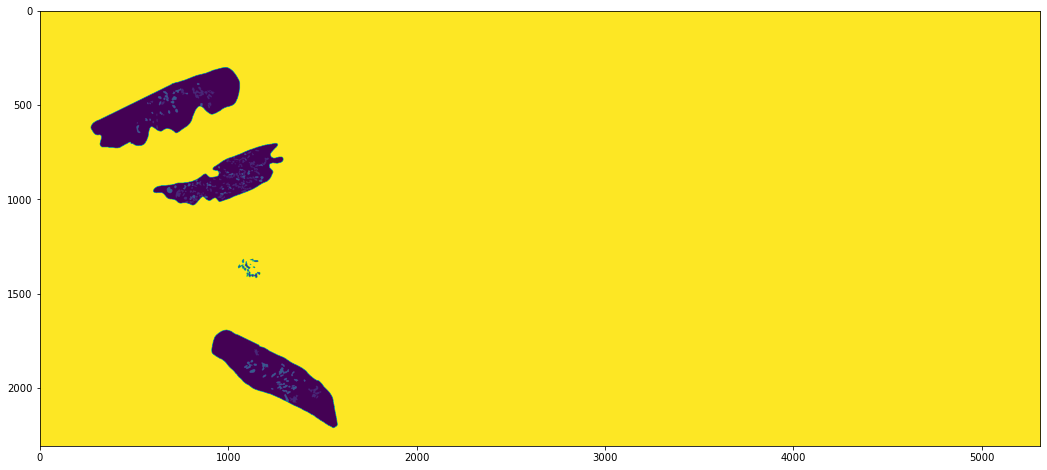

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.imshow(np.array(img_show))

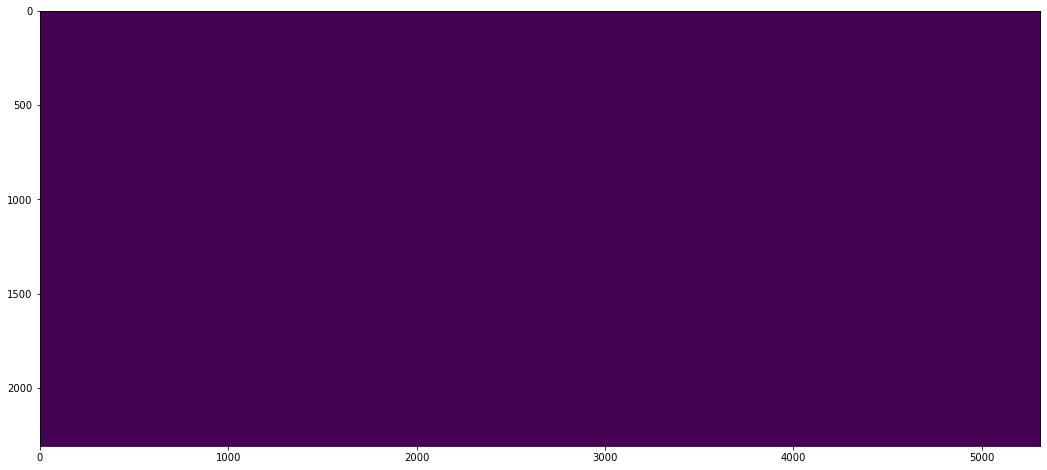

In [20]:
img_test = img_show.copy()
invasive_cancer = [75, 29]
normal_tissue = [225]
tumor = [0]
dcis_noncomedo = [102, 128]
dcis_comedo = [76, 106]
lcis = [204, 178]

def show_img(img, filter_1, filter_2 = 255):
    img_filter = cv2.inRange(img, filter_1, filter_1)
    if filter_2 != 255:
        img_filter2 = cv2.inRange(img, filter_2, filter_2)
        img_filter = cv2.add(img_filter, img_filter2)
    return img_filter

def img_plt(img):
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.imshow(np.array(img))

img_filter = show_img(img_test, 102, 128)
img_plt(img_filter)

In [21]:
def show_masks_data(img):
    check_1 = [invasive_cancer, normal_tissue, tumor, dcis_noncomedo, dcis_comedo, lcis]

    for count, i in enumerate(check_1):
        if len(i) > 1:
            filter_1 = i[0]
            filter_2 = i[1]
            img_filter = show_img(img, filter_1, filter_2)
        else:
            filter_1 = i[0]
            img_filter = show_img(img, filter_1)

        img_plt(img_filter)

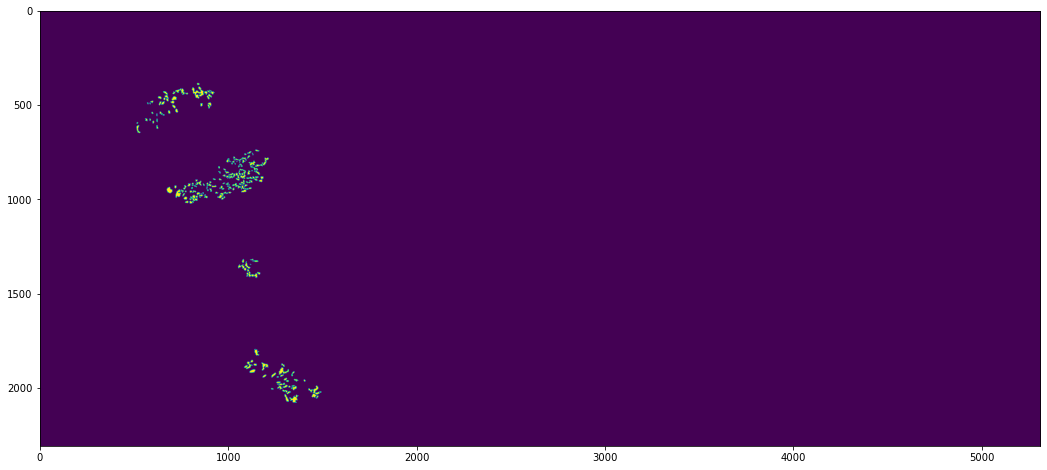

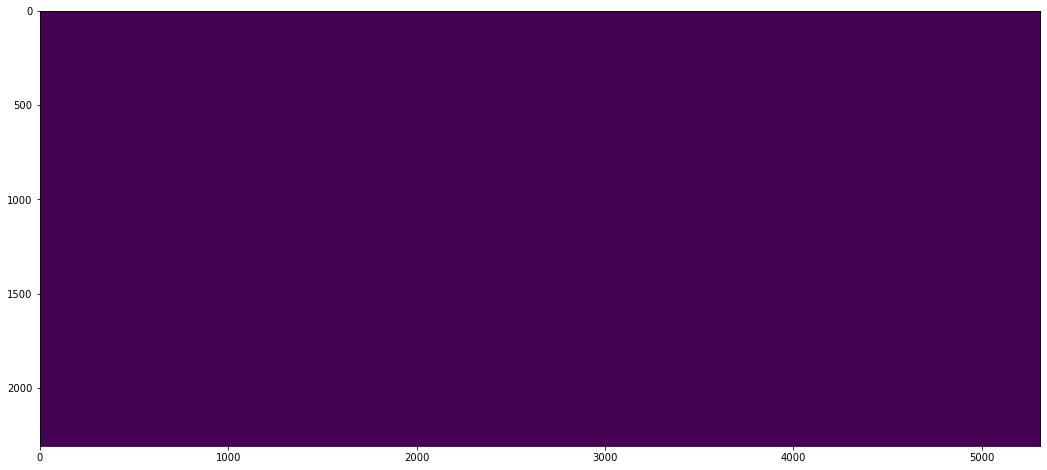

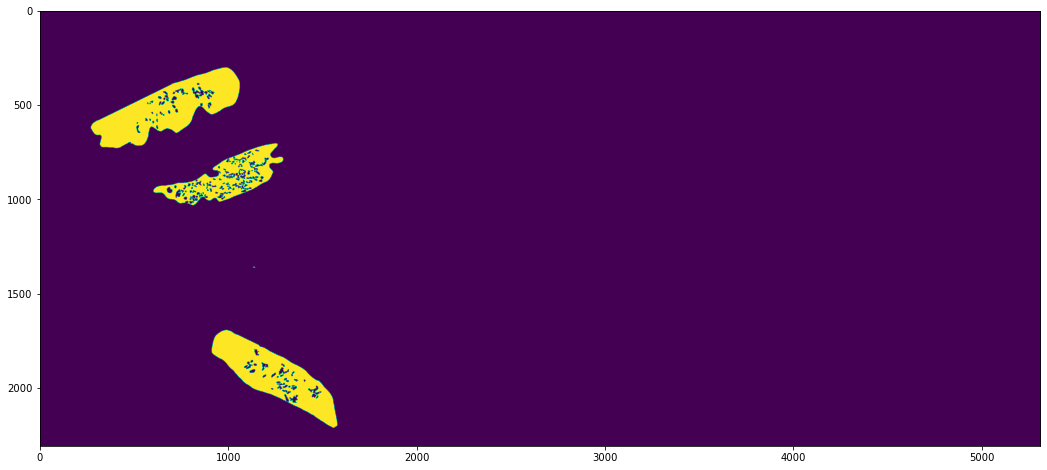

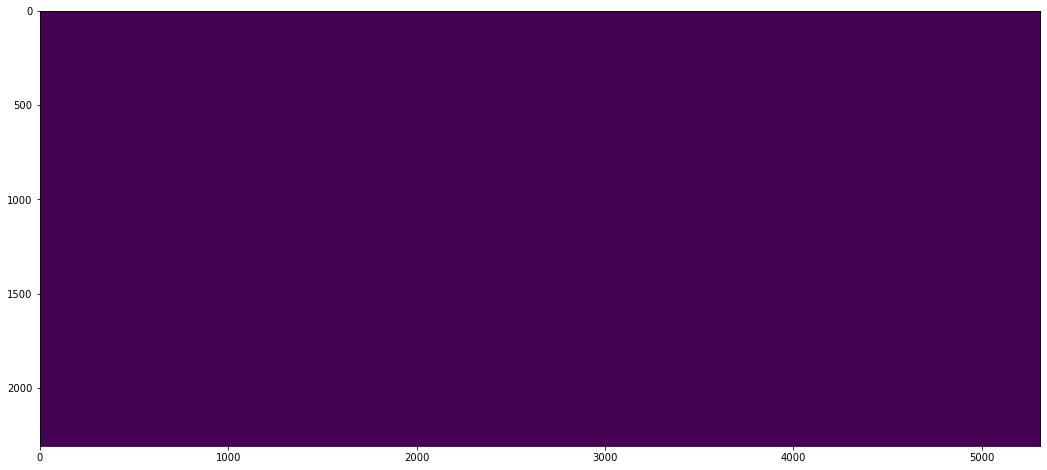

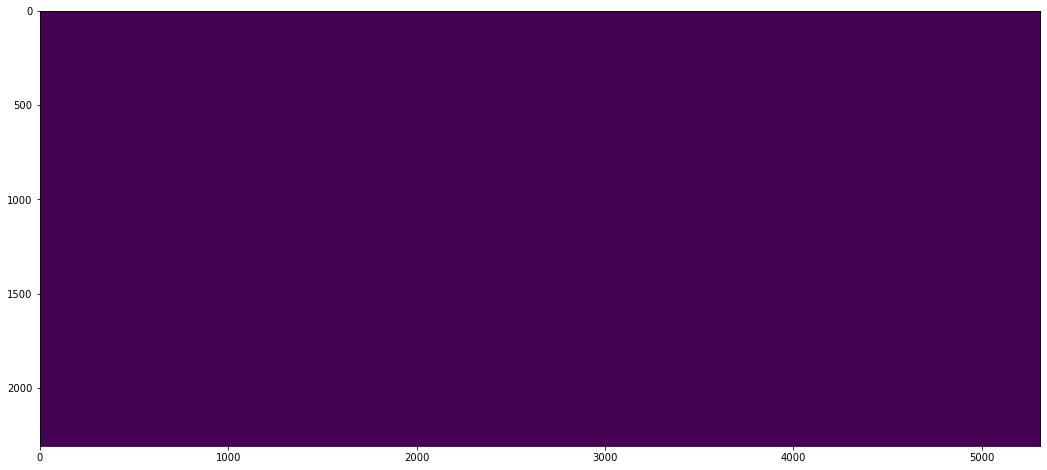

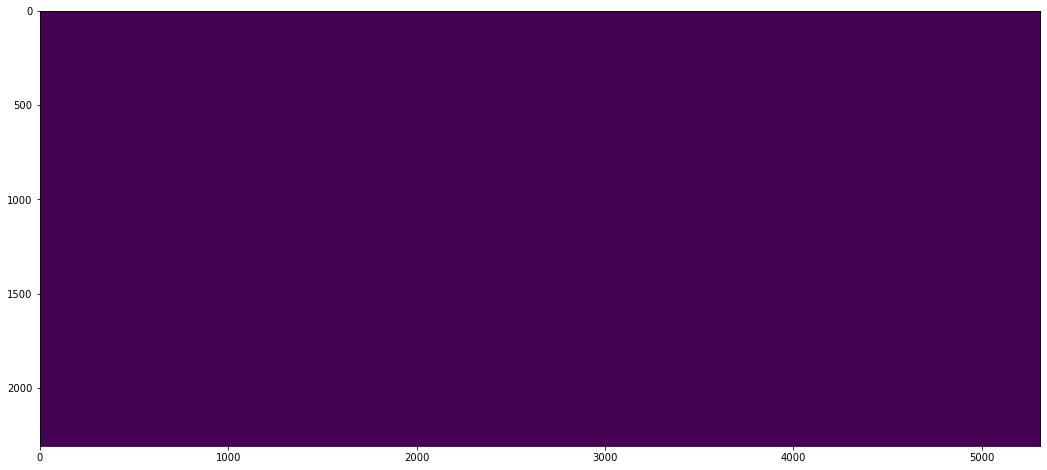

In [22]:
show_masks_data(img_test)

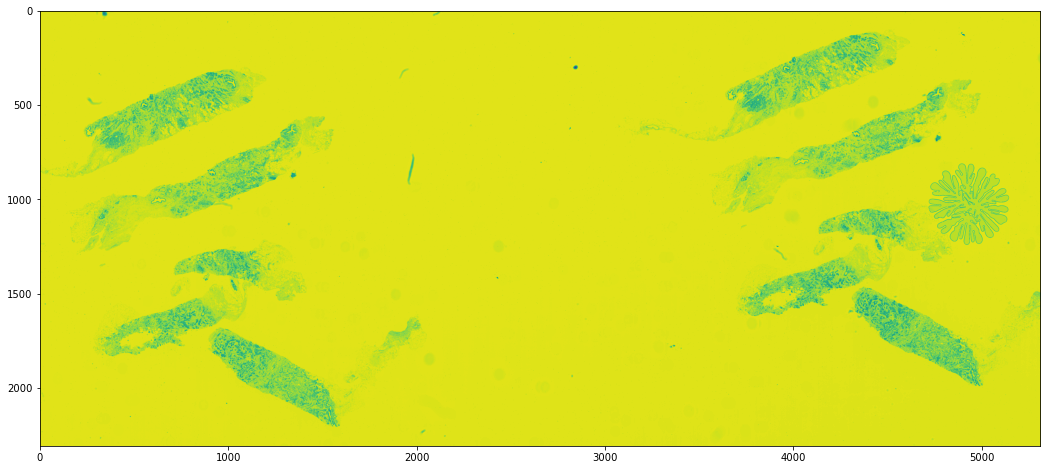

In [23]:
img_test_01 = cv2.cvtColor(cv2.imread(path + 'train_imgs/BC_01_0015.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
img_plt(img_test_01)

In [24]:
img_test_01

array([[244, 244, 244, ..., 244, 244, 244],
       [244, 244, 244, ..., 244, 244, 244],
       [244, 244, 244, ..., 244, 244, 244],
       ...,
       [244, 244, 244, ..., 242, 242, 242],
       [244, 244, 244, ..., 243, 242, 242],
       [244, 244, 244, ..., 243, 242, 242]], dtype=uint8)

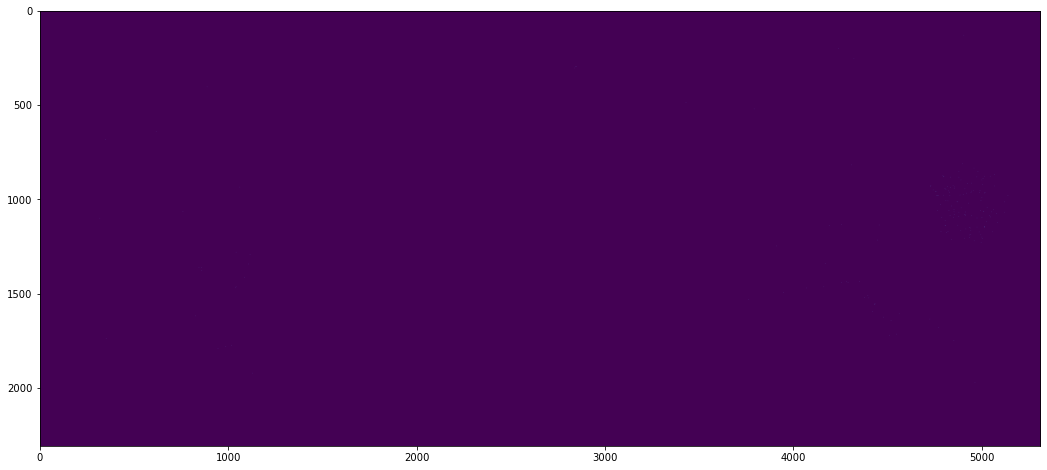

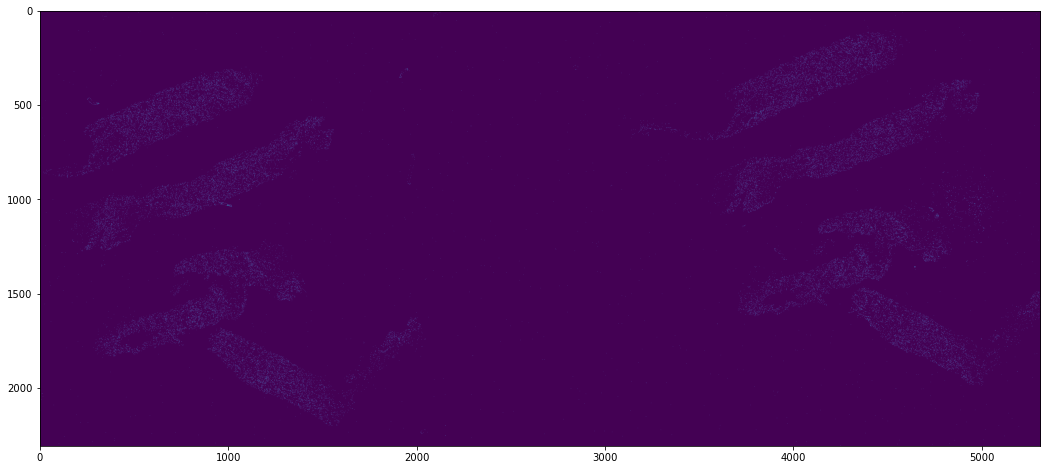

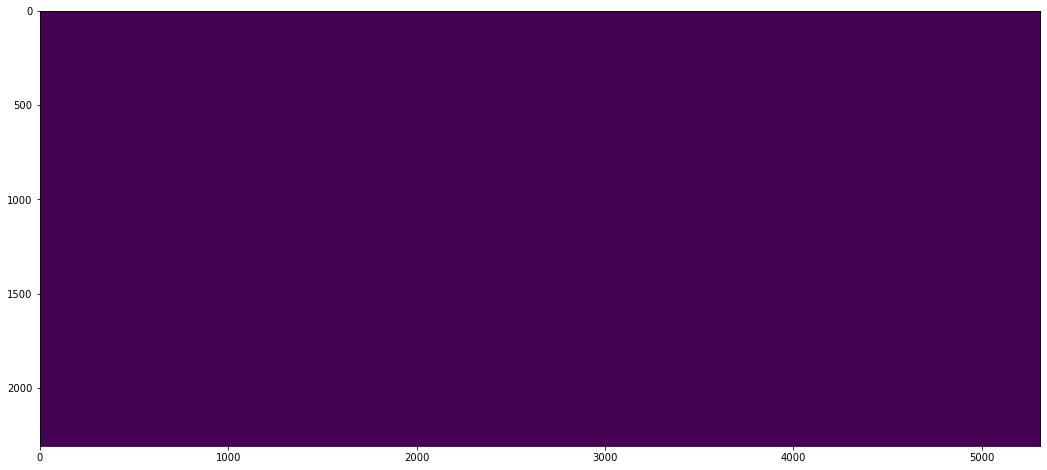

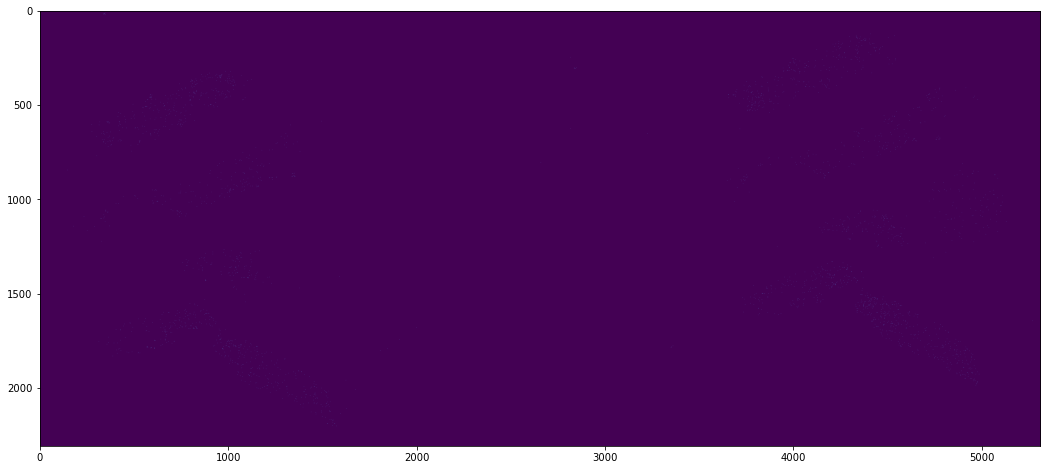

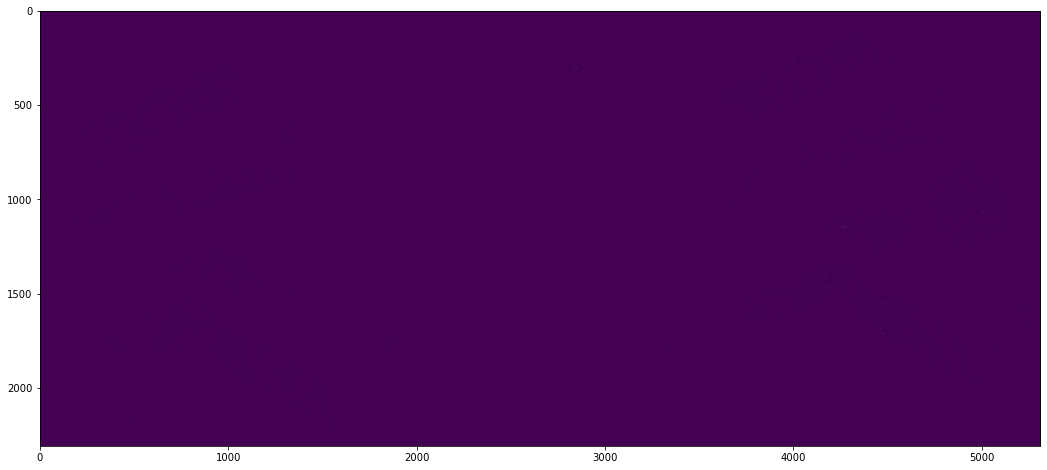

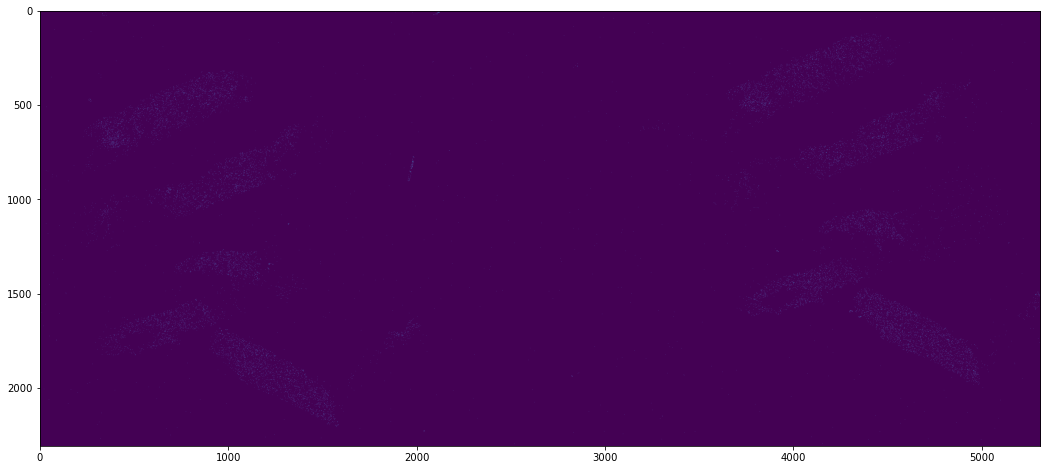

In [25]:
show_masks_data(img_test_01)

In [26]:
train

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,DCIS_or_LCIS_type,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,63,2015-10-23,1,2,1,19.000000,2.0,1.0,2.0,2.0,1.0,2,0.0,1.0,1.0,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,BC_01_0002,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,51,2015-10-28,1,1,1,22.000000,3.0,3.0,3.0,3.0,3.0,0,0.0,2.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,BC_01_0003,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,37,2015-10-29,1,2,1,18.375564,2.0,0.0,0.0,0.0,0.0,1,2.0,0.0,1.0,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,BC_01_0004,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,54,2016-03-08,1,2,1,0.000000,3.0,3.0,3.0,3.0,2.0,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,BC_01_0005,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,57,2015-10-30,1,2,1,8.000000,2.0,2.0,3.0,2.0,1.0,2,0.0,1.0,1.0,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,65,2006-12-22,1,2,1,25.000000,1.0,1.0,2.0,1.0,1.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1
996,BC_01_3482,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,48,2006-11-17,1,1,1,7.000000,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0
997,BC_01_3485,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,64,2006-11-10,1,2,1,15.000000,1.0,1.0,2.0,1.0,2.0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1
998,BC_01_3502,D:/Dataset/Competitons/cancer/train_imgs/BC_01...,D:/Dataset/Competitons/cancer/,50,2006-09-22,1,1,1,7.000000,1.0,1.0,1.0,2.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0


In [33]:
train_img = train[['img_path']]
train_img

,img_path
0,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
1,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
2,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
3,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
4,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
...,...
995,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
996,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
997,D:/Dataset/Competitons/cancer/train_imgs/BC_01...
998,D:/Dataset/Competitons/cancer/train_imgs/BC_01...


In [32]:
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tensorflow.keras.applications.xception import preprocess_input
import math

batch_size = 16
img_size = 520
img_channel = 1

class CustomSequence(Sequence):
    def __init__(self, filenames, target, batch_size, aug=None, shuffle=False):
        # image의 절대경로들
        self.filenames = filenames
        self.target = target
        self.batch_size = batch_size
        # albumentation 객체
        self.aug = aug
        self.shuffle = shuffle
        
        # 훈련 데이터의 경우
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        # 총 step의 갯수
        return math.ceil(len(self.filenames) / self.batch_size)

    def __getitem__(self, index):
        # 현재 인덱스를 기준으로 batch_size만큼 데이터를 가져옴
        meta_data = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # 훈련, 검증 데이터세트인 경우
        if self.target is not None:
            label_batch = self.target[index*self.batch_size:(index+1)*self.batch_size]

        # 불러온 meta_data를 np.array로 저장할 빈 공간을 생성
        image_batch = np.zeros((meta_data.shape[0], img_size, img_size, img_channel))
        for i in range(meta_data.shape[0]):
            # cv2는 이미지를 BGR로 불러오기 때문이 RGB로 바꾸어줌
            image = cv2.cvtColor(cv2.imread(meta_data[i]), cv2.COLOR_BGR2GRAY)
            # augmentation이 있으면 적용
            if self.aug is not None:
                image = self.aug(image=image)['image']

            # 이미지 값을 self.pre_func 함수로 스케일링
            image = image * 1./255

            # 빈 이미지 배치에 최종 이미지를 등록
            image_batch[i] = image
            
        if self.target is not None:
            return image_batch, label_batch
        else:
            return image_batch
        
    def on_epoch_end(self):
        # 파일과 라벨을 같이 섞어 주어야한다.
        if self.shuffle is True:
            self.image_filenames, self.target = shuffle(self.filenames, self.target)
        else:
            pass

In [38]:
train_img_dataset = CustomSequence(train_img, label, batch_size, preprocess_input)

In [35]:
def show_first_data(dataset, image_verbose=False):
    first_data = next(iter(dataset))
    images = first_data[0]
    labels = first_data[1]
    print(images.shape, labels.shape)
    print(images[0])
    if image_verbose:
        fig, axs = plt.subplots(figsize=(20, 8), nrows=1, ncols=4)
        for i in range(4):
            axs[i].imshow(np.array(images[i], dtype='int32'))

In [39]:
show_first_data(train_img_dataset)

KeyError: 0